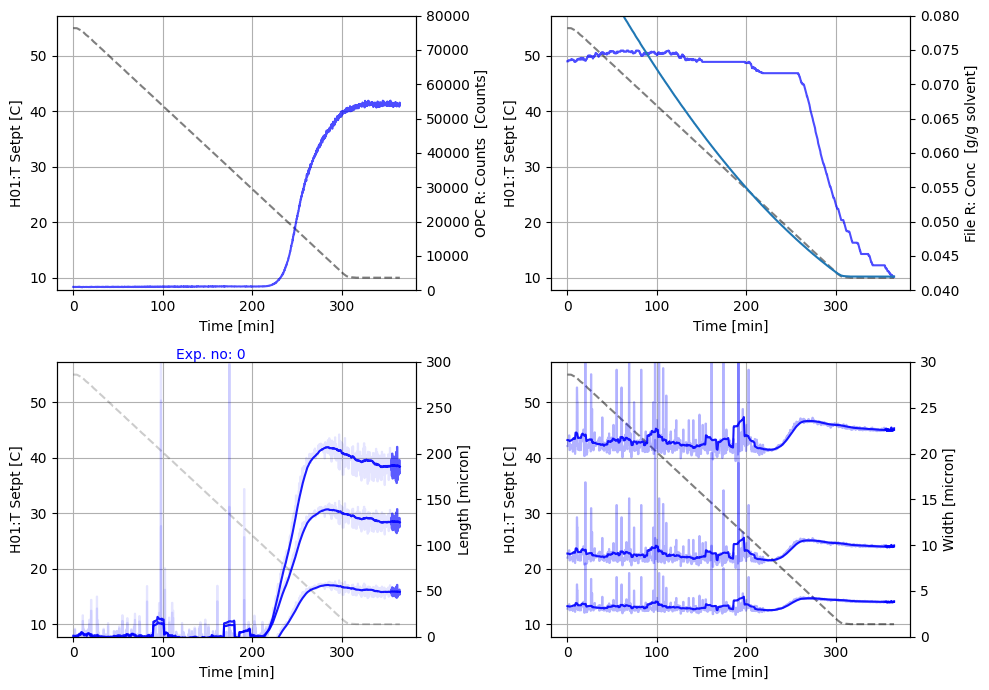

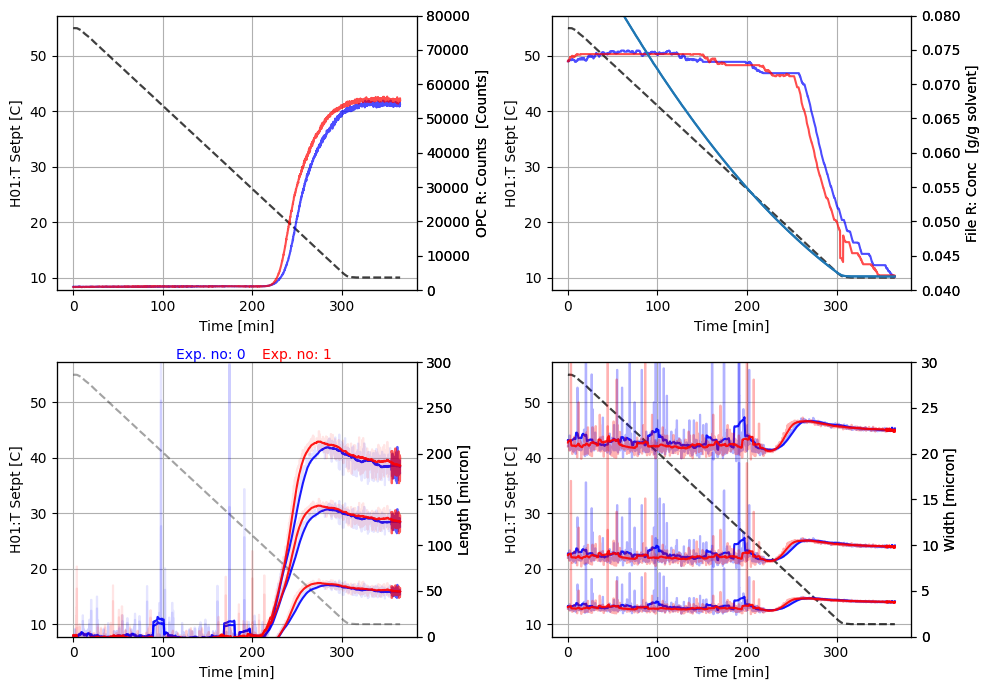

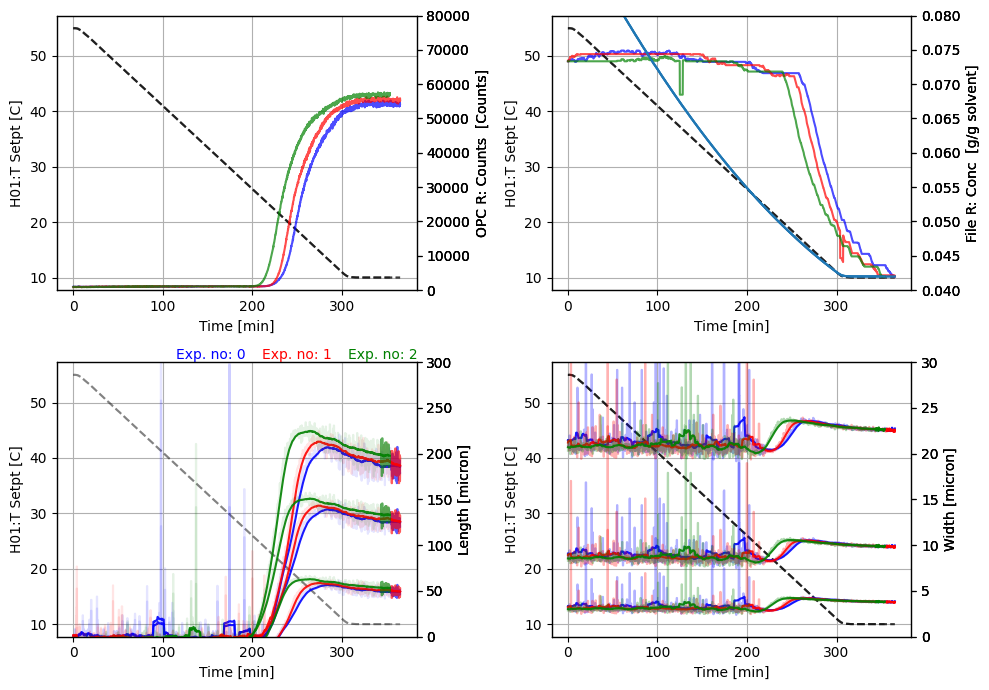

In [53]:
import os
import tkinter as tk
import subprocess
import time

from tkinter import ttk, messagebox
from enum import Enum  
from typing import Optional
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

from data_flow import Controller, Stage
from pure_functions import counter
from DataManager import DataManager

class MyApplication(tk.Tk):
    def __init__(self):
        
        super().__init__()
        self.OMNI = 'Omni_stage'
        self.IMED = 'Imed_stage'
        self.title("Or-Q")
        self.geometry("600x400")

        # ------------------------------------------------------------------------------------------------
        # -------------------------------------------- STYLE ---------------------------------------------
        # ------------------------------------------------------------------------------------------------
        
        style = ttk.Style(self)
        style.theme_use("alt")
        style.configure("TButton", font=("Montserrat", 8), padding=5)
        style.configure("Red.TButton", background="red", foreground="black", font=("Montserrat", 8))
        style.configure("Green.TButton", background="green", foreground="black", font=("Montserrat", 8))

        style.configure("TLabel", font=("Montserrat", 8), foreground="black", background="#f0f0f0")
        style.configure("Red.TLabel", foreground="red", font=("Montserrat", 8), background="#f0f0f0")
        style.configure("Green.TLabel",foreground="green", font=("Montserrat", 8), background="#f0f0f0")
        style.configure("Grey.TLabel",foreground="grey", font=("Montserrat", 8), background="#f0f0f0")
                
        style.map("TButton",background=[("active","lightgrey"),("pressed","lightgrey")],foreground=[("active","grey"),("pressed","grey")]) 
        style.map("Green.TButton",background=[("active","lightgreen"),("pressed","lightgreen")],foreground=[("active","green"),("pressed","green")])
        style.map("Red.TButton",background=[("active","pink"),("pressed","pink")],foreground=[("active","red"),("pressed","red")])
        
        # -------------------------------------------------------------------------------------------------------
        # -------------------------------------------- DEFINE VARIABLES -----------------------------------------
        # -------------------------------------------------------------------------------------------------------
        
        # Boolean variables
        self.variables_set = tk.BooleanVar(value = False)
        self.process_stop  = tk.BooleanVar(value = False)

        # Controlling the process in the background
        self.CONTROLLER : Controller | None = None

        # Data manipulation in the background
        self.DATAPROCESSOR : DataManager | None = None
        
        # Integer variables
        self.omni_run_count = tk.IntVar(value = 0) 
        self.imed_run_count = tk.IntVar(value = 0) 
        self.initial_exp_count = tk.IntVar(value = 0)

        # String variables
        self.status_message = tk.StringVar(value='') 
        self.error_message = tk.StringVar(value='') 
        self.variables_set_message = tk.StringVar(value='')
        self.omni_text   = tk.StringVar(value = "OMNIBUS")
        self.imed_text   = tk.StringVar(value = "IMED")
        self.omni_folder = tk.StringVar(value = "")
        self.imed_folder = tk.StringVar(value = "")
        self.exp_path_var = tk.StringVar(value = "")
        self.imed_path_var = tk.StringVar(value = "")
        self.exp_no_var = tk.StringVar(value = "")        
        self.omni_filename = 'expttsd'
        self.imed_filename = 'imed'

        self.create_labels()
        self.create_buttons()
        self.create_textboxes()
        self.layout_widgets()

        
        # --------------------------- Create Labels, Buttons, Textboxes ----------------------------------       

    def create_labels(self):
        # ---------------------
        # Create labels
        # ---------------------
        self.Omni_label1 = ttk.Label(self,  textvariable=self.omni_text)
        self.Imed_label1 = ttk.Label(self,  textvariable=self.imed_text)
        self.general_label1 = ttk.Label(self, text = 'Currently running:')
        self.general_label2 = ttk.Label(self, text = 'No. of runs:')
        self.general_label3 = ttk.Label(self, textvariable = self.status_message)
        self.general_label4 = ttk.Label(self, textvariable = self.error_message)
        self.general_label5 = ttk.Label(self, textvariable = self.variables_set_message)
        self.Omni_label2 = ttk.Label(self, text=str(self.omni_run_count.get()))
        self.Imed_label2 = ttk.Label(self, text=str(self.imed_run_count.get()))
        self.text_exp_loc_label1 = ttk.Label(self, text = 'Exp. folder path') 
        self.text_imed_loc_label1 = ttk.Label(self, text = 'IMED. folder path') 
        self.text_no_exp_label1 = ttk.Label(self, text = 'No. of exp:')
        
    
    def create_buttons(self):
        # ---------------------
        # Create buttons
        # ---------------------
        self.start_button  = ttk.Button(self, text="Start automated experiments", command=self.start_command)
        self.define_button = ttk.Button(self, text="Define settings", command=self.define_command)
        self.quit_button   = ttk.Button(self, text="Quit", width=8, command=self.destroy)         
        self.stop_button   = ttk.Button(self, text="Stop", width=8, command=self.stop_command)       
        self.reset_button  = ttk.Button(self, text="Reset",width=8, command=self.reset_command)
        self.plot_button   = ttk.Button(self, text="Plot data", command=self.plot_expts)
        
    
    def create_textboxes(self):
        # ---------------------
        # Create textboxes
        # ---------------------
        self.text_no_exp = ttk.Entry(self, textvariable=self.exp_no_var, width=5) 
        self.text_exp_loc = ttk.Entry(self, textvariable=self.exp_path_var, width=20)
        self.text_imed_loc = ttk.Entry(self, textvariable=self.imed_path_var, width=20)
    
    # ---------------------------------------------------------------------------------------------
    # ------------------------------------- PLACE VARIABLES ---------------------------------------
    # ---------------------------------------------------------------------------------------------
    
    def layout_widgets(self):
        # ---------------------
        # Place textboxes
        # ---------------------
        self.Omni_label1.place(x=400,y=210)
        self.Imed_label1.place(x=500,y=210)
        self.general_label1.place(x=400,y=180)
        self.general_label2.place(x=400,y=240)
        self.Omni_label2.place(x=400,y=270)
        self.Imed_label2.place(x=500,y=270)
        self.general_label3.place(x=150,y=70)
        self.general_label4.place(x=150,y=90)
        self.general_label5.place(x=150,y=180)
        self.text_exp_loc_label1.place(x=50,y=120)
        self.text_imed_loc_label1.place(x=50,y=160)
        self.text_no_exp_label1.place(x=70,y=140)
        self.define_button.place(x=150,y=200)     
        self.quit_button.place(x=30,y=270)
        self.start_button.place(x=30,y=310)   
        self.stop_button.place(x=300,y=270)
        self.plot_button.place(x=30,y=200)
        self.reset_button.place(x=300,y= 310)
        self.text_no_exp.place(x=150,y=140)
        self.text_exp_loc.place(x=150,y=120)
        self.text_imed_loc.place(x=150,y=160)    
    
    # -------------------------------------------------------------------------------------------------
    # ----------------------------------- HELPER FUNCTIONS  -------------------------------------------
    # -------------------------------------------------------------------------------------------------
    
    def set_buttons_enabled(self, enabled: bool):
        # -----------------------------------------------------------------------------------------
        # Enable / Disable buttons
        # -----------------------------------------------------------------------------------------
        flags = ["!disabled"] if enabled else ["disabled"]
        for btn in (self.start_button, self.define_button, self.quit_button, self.reset_button):#, self.plot_button):
            btn.state(flags)
        pass
    
    def check_if_empty_text(self):
        # -----------------------------------------------------------------------------------------
        # Check if textboxes are empty
        # -----------------------------------------------------------------------------------------
        return [len(i) != 0 for i in [self.text_exp_loc.get().strip(), self.text_imed_loc.get().strip(), self.text_no_exp.get().strip()]]      

    def upon_omni_finished(self):
        # ---------------------------------------------
        # change widgets when omni step completed
        # ---------------------------------------------
        self.Omni_label1.configure(style="Grey.TLabel")
        self.Imed_label1.configure(style="Green.TLabel")
        self.omni_run_count.set(self.CONTROLLER.omni_count)
        self.Omni_label2.config(text=str(self.CONTROLLER.omni_count))
        self.plot_button.state(["!disabled"])
        
    def upon_imed_finished(self):
        # ---------------------------------------------
        # change widgets when imed step completed
        # ---------------------------------------------
        self.Omni_label1.configure(style="Green.TLabel")
        self.Imed_label1.configure(style="Grey.TLabel")
        self.imed_run_count.set(self.CONTROLLER.imed_count)
        self.Imed_label2.config(text=str(self.CONTROLLER.imed_count))

    def monitoring_omni(self, check_frequency, num, path):
        # -----------------------------------------------------------------
        # monitoring the omni target folder for experiments to be created
        # -----------------------------------------------------------------
        if self.CONTROLLER.process_stop:
            return True      
            
        self.CONTROLLER.current_stage = Stage.OMNI
        
        if self.CONTROLLER.if_omni_finished(path,num):
            PATH = self.CONTROLLER.pathcreator_imed(self.CONTROLLER.omni_count, self.CONTROLLER.imed_folder)   
            self.CONTROLLER.omni_count += 1
            
            
            
            self.upon_omni_finished()
            # start IMED
            self.monitoring_imed(5, 1, PATH)
            return True
            
        else:
            self.Omni_label1.configure(style="Green.TLabel")
            self.Imed_label1.configure(style="Grey.TLabel")
            self.after(check_frequency * 1000, lambda: self.monitoring_omni(check_frequency, num, path))
            return False

    def monitoring_imed(self, check_frequency, num, path):
        # -----------------------------------------------------------------
        # monitoring the imed target folder for experiments to be created
        # -----------------------------------------------------------------

        if self.CONTROLLER.process_stop:
            return True 
            
        self.CONTROLLER.current_stage = Stage.IMED
        
        if self.CONTROLLER.if_imed_finished(path):
            self.CONTROLLER.imed_count += 1
            self.upon_imed_finished()
            PATH, exp_count = self.CONTROLLER.pathcreator_omni(self.CONTROLLER.imed_count, self.CONTROLLER.omni_folder)  
            self.monitoring_omni(5, exp_count, PATH)
            return True

        else:  
            self.Omni_label1.configure(style="Grey.TLabel")
            self.Imed_label1.configure(style="Green.TLabel")
            self.after(check_frequency * 1000, lambda: self.monitoring_imed(check_frequency, num, path))
            return False          
            
    
    # ---------------------------------------------------------------------------------------------    
    # ----------------------------------- BUTTON CALLS  -------------------------------------------
    # ---------------------------------------------------------------------------------------------
    
    def plot_expts(self):
        # -----------------------------------------------------------------------------------------
        # Create pop-up window of the processed experiments
        # -----------------------------------------------------------------------------------------
        if self.DATAPROCESSOR is not None:
            win = tk.Toplevel(self)
            win.title("Experiments so far")
            frame = ttk.Frame(win, padding=10)
            frame.pack(fill="both", expand=True)
            A = DataManager(self.omni_folder.get(), self.imed_folder.get())
            A.evaluator(True)
            fig = A.fig
            canvas = FigureCanvasTkAgg(fig, master=frame)
            canvas.draw()
            canvas.get_tk_widget().pack(fill="both", expand=True)

    def define_command(self):    
        # -----------------------------------------------------------------------------------------
        # Define initial data for process (file location, initial DoE experiment number)
        # -----------------------------------------------------------------------------------------
        self.status_message.set('')
        self.error_message.set('')
        self.variables_set_message.set('')
        self.variables_set.set(False)
        
        folder_loc      = self.text_exp_loc.get().strip() # Text box
        folder_imed_loc = self.text_imed_loc.get().strip() # Text box
        no_exp          = self.text_no_exp.get().strip() # Text box
    
        if not all( self.check_if_empty_text() ):
            
            self.status_message.set("Please dont leave any brackets empty")
            self.general_label3.config(style="Red.TLabel")
            self.define_button.config(style="Red.TButton")
            
        else:
            if all([os.path.isdir(folder_loc), os.path.isdir(folder_imed_loc)] ):
                self.omni_folder.set(folder_loc) 
                self.imed_folder.set(folder_imed_loc) 
                
                try:
                    no_exp_1 = int(no_exp)
                    if no_exp_1 <= 0:
                        self.error_message.set("Enter a positive integer")
                        self.general_label4.config(style="Red.TLabel")
                        self.define_button.config(style="Red.TButton")
                    else:
                        # if everything checks out, process is set for start
                        self.initial_exp_count.set(int(no_exp)) 
                        self.define_button.config(style="Green.TButton")
                        self.variables_set_message.set('Variables set')
                        self.general_label5.config(style="Green.TLabel")
                        self.variables_set.set(True)

                        # Create the controller object that handles the processes in the background: self.CONTROLLER = Controller(...)
                        self.CONTROLLER = Controller(self.omni_folder.get(), self.imed_folder.get(), self.initial_exp_count.get(), self.omni_filename, self.imed_filename)
                        self.CONTROLLER.exp_num(no_exp)
                        
                except ValueError:
                    self.error_message.set("Enter a valid integer")
                    self.define_button.config(style="Red.TButton")
            else:
                self.status_message.set("Enter a valid folder path")
                self.define_button.config(style="Red.TButton")  
                
    def start_command(self):
        # ----------------------------------------
        # start the automated OMNIBUS-->IMED loops
        # ----------------------------------------
        if not self.variables_set.get():         
            messagebox.showerror("Error", 'Please define variables first!')
            
        elif counter(self.omni_folder.get(), self.omni_filename) != 0:  
            messagebox.showerror("Error", 'Files \n already in experiment folder')

        elif counter(self.imed_folder.get(), self.imed_filename) != 0:    
            messagebox.showerror("Error", 'Files \n already in IMED folder')
        else:
            
            # START OMNIBUS (actually call folder and app on OMNI computer)
            
            self.CONTROLLER.process_stop = False
            self.set_buttons_enabled(False)
            # Control of processes
            self.CONTROLLER.start()
            # Store process exp info:
            self.DATAPROCESSOR = DataManager(self.omni_folder.get(), self.imed_folder.get())
            self.monitoring_omni(5, self.initial_exp_count.get(), self.omni_folder.get())
            
               
    def stop_command(self):
        # --------------------------------------------------------------
        # Terminate the processes (still in progress to complete)
        # --------------------------------------------------------------
        self.process_stop = False
        if not self.variables_set.get():
            messagebox.showerror("Error", 'Please define variables first!')
        else:
        
            self.Omni_label1.configure(style="Grey.TLabel")
            self.Imed_label1.configure(style="Grey.TLabel")
            self.set_buttons_enabled(True)
            # taskkill Application.exe -> cmd
            # taskkill IMED
            self.CONTROLLER.stop()

    def reset_command(self):        
        # ---------------------------------------------
        # reset all vairables and widgets
        # ---------------------------------------------
        self.variables_set_message.set("")
        self.variables_set.set(False) 
        self.process_stop = False 
        self.initial_exp_count.set(0)
        self.omni_run_count.set(0) 
        self.imed_run_count.set(0)
        self.status_message.set("") 
        self.error_message.set("") 
        self.omni_folder.set("")
        self.imed_folder.set("")
        self.exp_path_var.set("")
        self.imed_path_var.set("")
        self.exp_no_var.set("")     
        self.Omni_label1.configure(style="TLabel.TLabel")
        self.Imed_label1.configure(style="TLabel.TLabel")
        self.omni_run_count.set(0)
        self.imed_run_count.set(0)
        self.Omni_label2.config(text=str(self.omni_run_count.get()))
        self.Imed_label2.config(text=str(self.imed_run_count.get()))
        
        self.CONTROLLER : Controller  | None = None
        self.DATAPROCESSOR   : DataManager | None = None        
        
       

if __name__ == "__main__":
    app = MyApplication()
    app.mainloop()

# C:\Users\user\Desktop\OMNI\1. OMNI
# C:\Users\user\Desktop\OMNI\2. IMED

In [54]:
import os, shutil

folder_1 = r'C:\Users\user\Desktop\OMNI\1. OMNI'
folder_2 = r'C:\Users\user\Desktop\OMNI\2. IMED'

def folder_cleaner(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))
        pass        

folder_cleaner(folder_1)
folder_cleaner(folder_2)